In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

In [9]:
event_date = '2024-08-13'
prices = pd.read_csv('../Data Sources/prices.csv')
prices = prices[prices['returns'].isnull()==0].copy()
print(prices['date'].agg(['min','max']))
prices.head()

min    2024-01-03
max    2024-08-30
Name: date, dtype: str


,date,open,high,low,close,adjclose,volume,ticker,returns
0,2024-01-03,93.959999,94.239998,93.059998,93.230003,89.737869,7161700,SBUX,-0.004697
1,2024-01-04,93.099998,94.580002,93.000000,93.550003,90.045891,7118600,SBUX,0.003432
2,2024-01-05,93.330002,93.580002,92.480003,92.989998,89.506851,7189900,SBUX,-0.005986
3,2024-01-08,93.019997,94.570000,92.949997,94.190002,90.661919,7536900,SBUX,0.012905
4,2024-01-09,93.610001,93.730003,92.860001,93.089996,89.603111,6348500,SBUX,-0.011679


In [11]:
subset_prices = prices.pivot(index='date', columns='ticker', values='returns').reset_index()
subset_prices.sort_values('date', inplace=True)

subset_prices.columns.name = None
subset_prices['date'] = pd.to_datetime(subset_prices['date'])

subset_prices.head()

,date,MCD,SBUX,VOO,YUM
0,2024-01-03,-0.008921,-0.004697,-0.007419,0.000543
1,2024-01-04,-0.009002,0.003432,-0.003157,-0.003176
2,2024-01-05,-0.009426,-0.005986,0.001281,-0.002720
3,2024-01-08,0.010070,0.012905,0.014303,0.002338
4,2024-01-09,-0.003529,-0.011679,-0.002430,-0.003265


In [12]:
event_date = pd.to_datetime(event_date)

In [13]:
event_pos = subset_prices[subset_prices['date'] == event_date].index[0]
event_pos
subset_prices['trend'] = subset_prices.index - event_pos


In [14]:
subset_prices.head(-10)

,date,MCD,SBUX,VOO,YUM,trend
0,2024-01-03,-0.008921,-0.004697,-0.007419,0.000543,-153
1,2024-01-04,-0.009002,0.003432,-0.003157,-0.003176,-152
2,2024-01-05,-0.009426,-0.005986,0.001281,-0.002720,-151
3,2024-01-08,0.010070,0.012905,0.014303,0.002338,-150
4,2024-01-09,-0.003529,-0.011679,-0.002430,-0.003265,-149
...,...,...,...,...,...,...
152,2024-08-12,0.005785,0.025836,0.000510,-0.008480,-1
153,2024-08-13,0.003154,0.244970,0.016610,0.014451,0
154,2024-08-14,0.003108,-0.020855,0.003191,-0.002398,1
155,2024-08-15,0.013719,0.010437,0.017167,0.004007,2


In [15]:
preperiod_days = 90
postperiod_days = 1

subset = subset_prices[(subset_prices['trend'] >= -1*preperiod_days) & (subset_prices['trend'] < postperiod_days)].copy()
subset['event'] = np.where(subset['trend']==0, 1,0)

formula = "SBUX ~ MCD + VOO + YUM + event"
model = smf.ols(formula=formula, data=subset).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   SBUX   R-squared:                       0.645
Model:                            OLS   Adj. R-squared:                  0.629
Method:                 Least Squares   F-statistic:                     39.13
Date:                Sat, 28 Feb 2026   Prob (F-statistic):           1.25e-18
Time:                        15:17:43   Log-Likelihood:                 223.39
No. Observations:                  91   AIC:                            -436.8
Df Residuals:                      86   BIC:                            -424.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0011      0.002     -0.480      0.6

**Time varying effect**

In [16]:
preperiod_days = 90
postperiod_days = 4

subset_2 = subset_prices[(subset_prices['trend'] >= -1*preperiod_days) & (subset_prices['trend'] < postperiod_days)].copy()

subset_2['pre_3'] = subset_2['trend'].apply(lambda x: 1 if x==-3 else 0)
subset_2['pre_2'] = subset_2['trend'].apply(lambda x: 1 if x==-2 else 0)
subset_2['pre_1'] = subset_2['trend'].apply(lambda x: 1 if x==-1 else 0)
subset_2['event_0'] = subset_2['trend'].apply(lambda x: 1 if x==0 else 0)
subset_2['post_1'] = subset_2['trend'].apply(lambda x: 1 if x==1 else 0)
subset_2['post_2'] = subset_2['trend'].apply(lambda x: 1 if x==2 else 0)
subset_2['post_3'] = subset_2['trend'].apply(lambda x: 1 if x==3 else 0)

formula = "SBUX ~ MCD+VOO+YUM+pre_3+pre_2+pre_1+event_0+post_1+post_2+post_3"
model = smf.ols(formula=formula, data=subset_2).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   SBUX   R-squared:                       0.660
Model:                            OLS   Adj. R-squared:                  0.619
Method:                 Least Squares   F-statistic:                     16.10
Date:                Sat, 28 Feb 2026   Prob (F-statistic):           1.14e-15
Time:                        15:17:46   Log-Likelihood:                 233.98
No. Observations:                  94   AIC:                            -446.0
Df Residuals:                      83   BIC:                            -418.0
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0014      0.002     -0.626      0.5

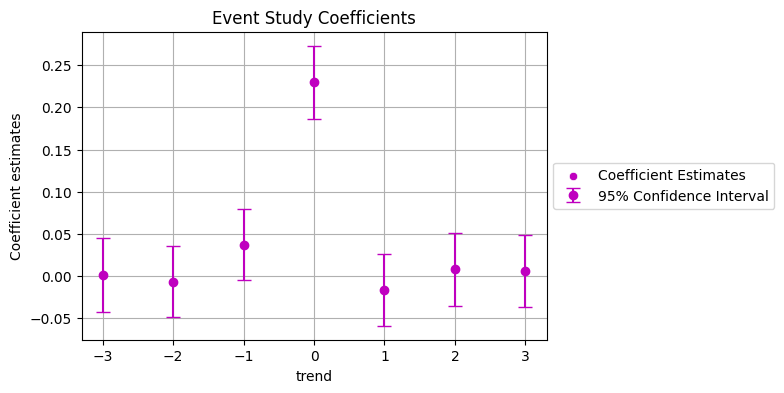

In [17]:
coefficients = model.bse.index[~model.bse.index.isin(['Intercept','MCD','VOO','YUM'])]
x_values = subset_prices[(subset_prices['trend'] >=-3) & (subset_prices['trend'] <=3)]['trend']
y_values = [model.params[coef] for coef in coefficients]


y_errors = [1.96*model.bse[coef] for coef in coefficients]

fig, ax = plt.subplots(figsize=(6,4))
sns.scatterplot(x=x_values, y=y_values, label='Coefficient Estimates', color='m')

plt.errorbar(x_values, y_values, yerr=y_errors, fmt='o', color='m', capsize=5, label='95% Confidence Interval')
ax.set_ylabel("Coefficient estimates")
ax.set_title("Event Study Coefficients")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.show()